In [159]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [160]:
# Read in loan data
df = pd.read_csv('output/LC_Final.csv.gz', compression='gzip')
df.head()

,Unnamed: 0,loan_amnt,term,int_rate,sub_grade,emp_length,home_ownership,annual_inc,verification_status,purpose,...,pub_rec,revol_bal,revol_util,initial_list_status,application_type,mo_sin_old_il_acct,mort_acc,earliest_cr_year,fico_score,charged_off
0,0,3600.0,36,13.99,C4,10.0,MORTGAGE,4.740371,Not Verified,debt_consolidation,...,0.0,3.441852,29.7,w,Individual,148.0,1.0,2003,677.0,0
1,1,24700.0,36,11.99,C1,10.0,MORTGAGE,4.812920,Not Verified,small_business,...,0.0,4.331852,19.2,w,Individual,113.0,4.0,1999,717.0,0
2,2,20000.0,60,10.78,B4,10.0,MORTGAGE,4.799347,Not Verified,home_improvement,...,0.0,3.895975,56.2,w,Joint App,125.0,5.0,2000,697.0,0
3,4,10400.0,60,22.45,F1,3.0,MORTGAGE,5.018842,Source Verified,major_purchase,...,0.0,4.341039,64.5,w,Individual,128.0,6.0,1998,697.0,0
4,5,11950.0,36,13.44,C3,4.0,RENT,4.531492,Source Verified,debt_consolidation,...,0.0,3.945616,68.4,w,Individual,338.0,0.0,1987,692.0,0


In [161]:
# Drop extra index column
df = df.drop('Unnamed: 0', axis=1)
print(df.columns)

Index(['loan_amnt', 'term', 'int_rate', 'sub_grade', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'purpose',
       'addr_state', 'dti', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'initial_list_status', 'application_type', 'mo_sin_old_il_acct',
       'mort_acc', 'earliest_cr_year', 'fico_score', 'charged_off'],
      dtype='object')


In [162]:
# check for columns needing label encoding
for col in df.columns.values:
    # Encode only the columns with categorical values
    print(df[col].dtypes)

float64
int64
float64
object
float64
object
float64
object
object
object
float64
float64
float64
float64
float64
object
object
float64
float64
int64
float64
int64


In [163]:
# Label encoding categorical values
le = LabelEncoder()

# Iterate over columns in dataframe
for col in df.columns.values:
    # Encode only the columns with categorical values
    if df[col].dtypes == 'object':
        data = df[col].append(df[col])
        le.fit(data.values)
        df[col] = le.transform(df[col])
        
df.head()

,loan_amnt,term,int_rate,sub_grade,emp_length,home_ownership,annual_inc,verification_status,purpose,addr_state,...,pub_rec,revol_bal,revol_util,initial_list_status,application_type,mo_sin_old_il_acct,mort_acc,earliest_cr_year,fico_score,charged_off
0,3600.0,36,13.99,13,10.0,0,4.740371,0,2,38,...,0.0,3.441852,29.7,1,0,148.0,1.0,2003,677.0,0
1,24700.0,36,11.99,10,10.0,0,4.812920,0,11,41,...,0.0,4.331852,19.2,1,0,113.0,4.0,1999,717.0,0
2,20000.0,60,10.78,8,10.0,0,4.799347,0,4,14,...,0.0,3.895975,56.2,1,1,125.0,5.0,2000,697.0,0
3,10400.0,60,22.45,25,3.0,0,5.018842,1,6,38,...,0.0,4.341039,64.5,1,0,128.0,6.0,1998,697.0,0
4,11950.0,36,13.44,12,4.0,3,4.531492,1,2,10,...,0.0,3.945616,68.4,1,0,338.0,0.0,1987,692.0,0


In [164]:
# Confirm label encoding
for col in df.columns.values:
    # Encode only the columns with categorical values
    print(df[col].dtypes)

float64
int64
float64
int32
float64
int32
float64
int32
int32
int32
float64
float64
float64
float64
float64
int32
int32
float64
float64
int64
float64
int64


In [165]:
# Check for null values
df.isna().any()

loan_amnt              False
term                   False
int_rate               False
sub_grade              False
emp_length              True
home_ownership         False
annual_inc             False
verification_status    False
purpose                False
addr_state             False
dti                     True
open_acc               False
pub_rec                False
revol_bal              False
revol_util              True
initial_list_status    False
application_type       False
mo_sin_old_il_acct      True
mort_acc                True
earliest_cr_year       False
fico_score             False
charged_off            False
dtype: bool

In [166]:
# Check number of null values
df.isna().sum()

loan_amnt                   0
term                        0
int_rate                    0
sub_grade                   0
emp_length              78511
home_ownership              0
annual_inc                  0
verification_status         0
purpose                     0
addr_state                  0
dti                       374
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util                857
initial_list_status         0
application_type            0
mo_sin_old_il_acct     105575
mort_acc                47281
earliest_cr_year            0
fico_score                  0
charged_off                 0
dtype: int64

In [167]:
# Drop null values
df.dropna(inplace=True)

In [36]:
#Null Value Imputation Option
rev_null=['emp_length', 'dti', 'revol_util', 'mo_sin_old_il_acct', 'mort_acc',]
df[rev_null]=df[rev_null].replace({np.nan:df['emp_length'].mean(),
                                   np.nan:df['dti'].mean(),
                                   np.nan:df['revol_util'].mean(),
                                   np.nan:df['mo_sin_old_il_acct'].mean(),
                                   np.nan:df['mort_acc'].mean()})

In [168]:
# Confirm null values removed
df.isna().any()

loan_amnt              False
term                   False
int_rate               False
sub_grade              False
emp_length             False
home_ownership         False
annual_inc             False
verification_status    False
purpose                False
addr_state             False
dti                    False
open_acc               False
pub_rec                False
revol_bal              False
revol_util             False
initial_list_status    False
application_type       False
mo_sin_old_il_acct     False
mort_acc               False
earliest_cr_year       False
fico_score             False
charged_off            False
dtype: bool

In [169]:
# Checking ratio of charged off data
df['charged_off'].value_counts()

0    937174
1    230778
Name: charged_off, dtype: int64

In [197]:
cropped_df = df.iloc[0:5000,:]
cropped_df['charged_off'].value_counts()

0    4073
1     927
Name: charged_off, dtype: int64

In [198]:
cropped_df = df.iloc[0:5000,:]

cropped_df_major = cropped_df[cropped_df.charged_off == 0]
cropped_df_minor = cropped_df[cropped_df.charged_off == 1]
cdf_minor_upsmapled = resample(cropped_df_minor, replace = True, n_samples = 4073, random_state = 1019)
cdf_minor_upsmapled = pd.concat([cdf_minor_upsmapled, cropped_df_major])

ctarget = cdf_minor_upsmapled["charged_off"]
cdata = cdf_minor_upsmapled.drop("charged_off", axis=1)

In [150]:
#cropped_df['charged_off'].value_counts()
cdf_minor_upsmapled.charged_off.value_counts()

1    835
0    835
Name: charged_off, dtype: int64

In [170]:
df_major = df[df.charged_off == 0]
df_minor = df[df.charged_off == 1]
df_minor_upsmapled = resample(df_minor, replace = True, n_samples = 937174, random_state = 1019)
df_minor_upsmapled = pd.concat([df_minor_upsmapled, df_major])
df_minor_upsmapled.charged_off.value_counts()

1    937174
0    937174
Name: charged_off, dtype: int64

In [171]:
# Separate the targeted 'charged_off' column to create training/testing sets
target = df_minor_upsmapled["charged_off"]
target_names = ["Approve", "Deny"]

data = df_minor_upsmapled.drop("charged_off", axis=1)
feature_names = data.columns

In [41]:
# Split the dataset in 80:20 ratio for training and test
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.2, random_state=42)

In [172]:
# Split the dataset in 60:20:20 ratio for training, validation, test
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2

In [200]:
CX_train, CX_test, cy_train, cy_test = train_test_split(cdata, ctarget, test_size=0.2, random_state=42)

CX_train, CX_val, cy_train, cy_val = train_test_split(CX_train, cy_train, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2

In [173]:
# Print out the shape of the created train/test sets
print('Shape of X_train =>',X_train.shape)
print('Shape of X_val =>',X_val.shape)
print('Shape of X_test =>',X_test.shape)
print('Shape of Y_train =>',y_train.shape)
print('Shape of Y_val =>',y_val.shape)
print('Shape of Y_test =>',y_test.shape)

Shape of X_train => (1124608, 21)
Shape of X_val => (374870, 21)
Shape of X_test => (374870, 21)
Shape of Y_train => (1124608,)
Shape of Y_val => (374870,)
Shape of Y_test => (374870,)


In [174]:
# Build the random forest classifier
rfc = RandomForestClassifier(criterion = 'gini', max_depth = 15, n_estimators = 750)

In [201]:
crfc = RandomForestClassifier(criterion = 'gini', max_depth = 15, n_estimators = 750)

In [101]:
cparam_grid = {'max_features': ['auto', 'sqrt', 'log2'],
               'n_estimators': [100, 500, 750],
               'max_depth': [5, 15, 30],
               'criterion' : ['gini', 'entropy']}
grid = GridSearchCV(crfc, cparam_grid)

In [125]:
grid.fit(X_val, y_val)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=15,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=750, n_jobs=None,
                                              oob_score=False,
                                              rand

In [103]:
# List the best parameters for this dataset
print(grid.best_params_)

{'criterion': 'gini', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 750}


In [104]:
# List the best score
print(grid.best_score_)

0.8052793127896894


In [202]:
crfc = crfc.fit(CX_train, cy_train)

In [175]:
rfc = rfc.fit(X_train, y_train)

In [203]:
cpredval = crfc.predict(CX_val)

In [176]:
predval = rfc.predict(X_val)

In [70]:
(y_val == predval).sum()

187940

In [204]:
print(classification_report(cy_val, cpredval, target_names=target_names))

              precision    recall  f1-score   support

     Approve       0.95      0.88      0.91       823
        Deny       0.88      0.95      0.91       806

    accuracy                           0.91      1629
   macro avg       0.91      0.91      0.91      1629
weighted avg       0.91      0.91      0.91      1629



In [205]:
cpredtest = crfc.predict(CX_test)

In [206]:
print(classification_report(cy_test, cpredtest, target_names=target_names))

              precision    recall  f1-score   support

     Approve       0.95      0.87      0.91       812
        Deny       0.88      0.95      0.91       818

    accuracy                           0.91      1630
   macro avg       0.91      0.91      0.91      1630
weighted avg       0.91      0.91      0.91      1630



In [207]:
crfc.score(CX_test, cy_test)

0.90920245398773

In [107]:
# After resampling, but before hypertuning
print(classification_report(cy_val, cpredval, target_names=target_names))

              precision    recall  f1-score   support

     Approve       0.98      0.91      0.95       173
        Deny       0.91      0.98      0.95       161

    accuracy                           0.95       334
   macro avg       0.95      0.95      0.95       334
weighted avg       0.95      0.95      0.95       334



In [186]:
# Get numerical feature importances
importances = list(crfc.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_names, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('{:20} Importance: {}'.format(*pair)) for pair in feature_importances]

int_rate             Importance: 0.09
sub_grade            Importance: 0.09
dti                  Importance: 0.08
loan_amnt            Importance: 0.07
revol_bal            Importance: 0.07
revol_util           Importance: 0.07
mo_sin_old_il_acct   Importance: 0.07
fico_score           Importance: 0.07
annual_inc           Importance: 0.06
earliest_cr_year     Importance: 0.06
addr_state           Importance: 0.05
open_acc             Importance: 0.05
mort_acc             Importance: 0.04
term                 Importance: 0.03
emp_length           Importance: 0.03
purpose              Importance: 0.03
home_ownership       Importance: 0.02
verification_status  Importance: 0.02
pub_rec              Importance: 0.01
initial_list_status  Importance: 0.0
application_type     Importance: 0.0


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [112]:
# With hypertuned parameters
print(classification_report(cy_val, cpredval, target_names=target_names))

              precision    recall  f1-score   support

     Approve       0.98      0.92      0.95       173
        Deny       0.92      0.98      0.95       161

    accuracy                           0.95       334
   macro avg       0.95      0.95      0.95       334
weighted avg       0.95      0.95      0.95       334



In [75]:
# Before resampling
print(classification_report(y_val, predval, target_names=target_names))

              precision    recall  f1-score   support

     Approve       0.81      0.98      0.89    187324
        Deny       0.55      0.08      0.14     46267

    accuracy                           0.80    233591
   macro avg       0.68      0.53      0.51    233591
weighted avg       0.76      0.80      0.74    233591



In [78]:
print(confusion_matrix(y_val, predval))

[[184266   3058]
 [ 42593   3674]]


In [81]:
# Score test
rfc.score(X_val, y_val)

0.804568669169617

In [52]:
# Score test
rfc.score(CX_test, cy_test)

0.8041603793921104

In [68]:
# Evaluating on Training set
rfc_pred_train = rfc.predict(X_train)
print('Training Set Evaluation F1-Score=>',f1_score(y_train,rfc_pred_train))

Training Set Evaluation F1-Score=> 0.9999386739873091


In [56]:
# Evaluating on Test set
rfc_pred_test = rfc.predict(X_test)
print('Testing Set Evaluation F1-Score=>',f1_score(y_test,rfc_pred_test))

Testing Set Evaluation F1-Score=> 0.13576946417149138


In [178]:
# Sort feature importance 
sorted(zip(rfc.feature_importances_, feature_names), reverse=True)

[(0.20979961060770771, 'sub_grade'),
 (0.1778802932091984, 'int_rate'),
 (0.07184120329323943, 'term'),
 (0.06627625445621438, 'dti'),
 (0.056942386565418585, 'fico_score'),
 (0.05205518553370215, 'loan_amnt'),
 (0.04436926425063762, 'revol_bal'),
 (0.04242638101277597, 'annual_inc'),
 (0.04161345929132065, 'revol_util'),
 (0.03877150464598106, 'mo_sin_old_il_acct'),
 (0.030999039846586272, 'earliest_cr_year'),
 (0.029332986481423476, 'addr_state'),
 (0.028899799293252693, 'open_acc'),
 (0.02794977660522055, 'mort_acc'),
 (0.018209951545488493, 'home_ownership'),
 (0.017584375885700602, 'emp_length'),
 (0.016658501139885862, 'verification_status'),
 (0.014822164006187062, 'purpose'),
 (0.006196631807150259, 'pub_rec'),
 (0.00533352498862588, 'initial_list_status'),
 (0.002037705534283107, 'application_type')]

In [191]:
features_response = feature_names.tolist()

feat_imp_df = pd.DataFrame({
    'Feature name':features_response,
    'Importance':rfc.feature_importances_
})

In [192]:
feat_imp_df.sort_values('Importance', ascending=False)

,Feature name,Importance
3,sub_grade,0.209800
2,int_rate,0.177880
1,term,0.071841
10,dti,0.066276
20,fico_score,0.056942
0,loan_amnt,0.052055
13,revol_bal,0.044369
6,annual_inc,0.042426
14,revol_util,0.041613
17,mo_sin_old_il_acct,0.038772


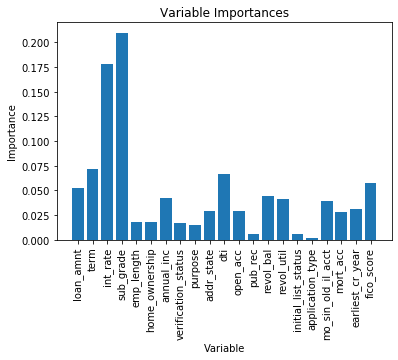

In [184]:
# Set the style
#plt.style.use('fivethirtyeight')

# list of x locations for plotting
x_values = list(range(len(rfc.feature_importances_)))
# Make a bar chart
plt.bar(x_values, rfc.feature_importances_, orientation = 'vertical')
plt.barh(feature_names, x_values)
# Tick labels for x axis
plt.xticks(x_values, feature_names, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');